# Neural Networks

In this notebook we are going to explore the Neural Networks for image classification. We are going to use the same dataset of the SVM notebook: Fashion MNIST (https://pravarmahajan.github.io/fashion/), a dataset of small images of clothes and accessories.

The dataset labels are the following:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [1]:
#load the required packages

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import pandas as pd

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
# helper function to load Fashion MNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

# TODO 
Place your ID ("numero di matricola") that will be used as seed for random generator. You can try to change the seed to see the impact of the randomization.

In [3]:
ID = 1183845
np.random.seed(ID)

In [4]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
# rescale the data
X = X / 255.0

Now split into training and test. Make sure that each label is present at least 10 times
in training frequencies.

In [5]:
#random permute the data and split into training and test taking the first 500
#data samples as training and the rests as test
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 500

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)

#making sure that each label is present at least 10 times in training
if np.all(freqs>10)==False:
    for item in freqs:
        while item<10:
            X = X[permutation]
            y = y[permutation]
    
            X_train, X_test = X[:m_training], X[m_training:]
            y_train, y_test = y[:m_training], y[m_training:]


print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [50 50 44 53 48 49 48 57 50 51]


In [6]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


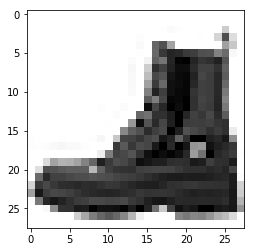

LABEL: 9
INPUT:


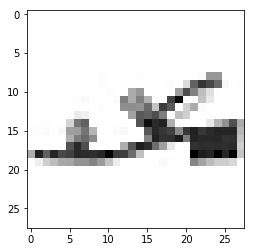

LABEL: 5
INPUT:


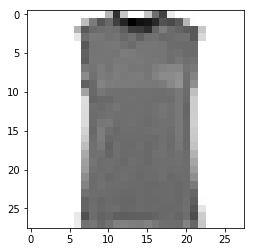

LABEL: 0


In [7]:
#let's try the plotting function
plot_input(X_train,y_train,10)
plot_input(X_test,y_test,100)
plot_input(X_test,y_test,10000)

## TO DO 1

Now use a Feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 100. Evaluate the architectures you chose using the GridSearchCV with cv=5.


In [8]:
parameters = {'hidden_layer_sizes': [(10,), (50,), (10,10,), (50,50,), (10, 10, 10,), (50, 50, 50,)]}

mlp = MLPClassifier(max_iter=300, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=ID,
                    learning_rate_init=.1)

#ADD YOUR CODE
ffnn = GridSearchCV(estimator=mlp, param_grid=parameters, cv=5, return_train_score=True)
ffnn.fit(X_train, y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:", ffnn.best_params_)
print("Score with best parameters:", ffnn.best_score_)

print("\nAll scores on the grid:")
results = pd.DataFrame(ffnn.cv_results_)
results[["params", "mean_test_score"]]

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RESULTS FOR NN

Best parameters set found: {'hidden_layer_sizes': (50,)}
Score with best parameters: 0.63

All scores on the grid:


,params,mean_test_score
0,"{'hidden_layer_sizes': (10,)}",0.524
1,"{'hidden_layer_sizes': (50,)}",0.630
2,"{'hidden_layer_sizes': (10, 10)}",0.520
3,"{'hidden_layer_sizes': (50, 50)}",0.560
4,"{'hidden_layer_sizes': (10, 10, 10)}",0.356
5,"{'hidden_layer_sizes': (50, 50, 50)}",0.590


### QUESTION 1

What do you observe for different architectures and their scores? How the nummber of layers and their sizes affect the performances?

Having a look at the mean test scores for each of the different architectures that have been tried out, we can say that:
* when the sizes of the layers increase (from 10 to 50), the score increases as well, hence improving performances;
* when we have more layers (fixing their size), the score appears to decrease in almost all cases.

As a consequence, the scenario where we get the best parameters is the one with (50,) - that is, number 2.

### TO DO 2

Now get training and test error for a NN with best parameters from above. Use verbose=True
in input so to see how loss changes in iterations

In [9]:
#get training and test error for the best NN model from CV
best_ffnn = MLPClassifier(hidden_layer_sizes=(50, ), solver='sgd', alpha=1e-4, learning_rate_init=.1, 
                          max_iter=300,random_state=ID, tol=1e-4, verbose=True)
best_ffnn.fit(X_train, y_train)

training_error = 1. - best_ffnn.score(X_train,y_train)
test_error = 1. - best_ffnn.score(X_test,y_test)

print ('\nRESULTS FOR BEST NN\n')
print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)

Iteration 1, loss = 2.20709113
Iteration 2, loss = 1.58092676
Iteration 3, loss = 1.04877785
Iteration 4, loss = 0.95728295
Iteration 5, loss = 0.85152831
Iteration 6, loss = 0.84805561
Iteration 7, loss = 0.78365404
Iteration 8, loss = 0.59408188
Iteration 9, loss = 0.53748501
Iteration 10, loss = 0.48523290
Iteration 11, loss = 0.47653705
Iteration 12, loss = 0.42789412
Iteration 13, loss = 0.43477578
Iteration 14, loss = 0.39520856
Iteration 15, loss = 0.39110936
Iteration 16, loss = 0.46561793
Iteration 17, loss = 0.32014194
Iteration 18, loss = 0.28971269
Iteration 19, loss = 0.26288025
Iteration 20, loss = 0.28594733
Iteration 21, loss = 0.24149119
Iteration 22, loss = 0.24449154
Iteration 23, loss = 0.21625660
Iteration 24, loss = 0.18791435
Iteration 25, loss = 0.17748568
Iteration 26, loss = 0.17024069
Iteration 27, loss = 0.14519383
Iteration 28, loss = 0.12617748
Iteration 29, loss = 0.12270315
Iteration 30, loss = 0.14451011
Iteration 31, loss = 0.11788765
Iteration 32, los

## More data 
Now let's do the same but using 10000 (or less if it takes too long on your machine) data points for training. Use the same NN architectures as before, but you can try more if you want!

In [10]:
X = X[permutation]
y = y[permutation]

m_training = 10000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

print("Labels and frequencies in training dataset: ")
np.unique(y_train, return_counts=True)

Labels and frequencies in training dataset: 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1041,  977, 1051, 1010,  985,  984,  983,  990,  991,  988]))

## TO DO 3

Now train the NNs with the added data points. Feel free to try more different architectures than before if you want, or less if it takes too much time. We suggest that you use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).

In [11]:
#for NN we try the same architectures as before
parameters = {'hidden_layer_sizes': [(10,), (50,), (10,10,), (50,50,), (10, 10, 10,), (50, 50, 50,), 
                                     (10, 10, 10, 10,), (50, 50, 50, 50,)]}

mlp_large_CV = MLPClassifier(max_iter=300, alpha=1e-4,
                             solver='sgd', tol=1e-4, random_state=ID,
                             learning_rate_init=.1)

clf_large_CV = GridSearchCV(estimator=mlp_large_CV, param_grid=parameters, cv=5, return_train_score=True)
clf_large_CV.fit(X_train, y_train)


print ('\nRESULTS FOR NN\n')

print("Best parameters set found:")
print(clf_large_CV.best_params_)

print("Score with best parameters:")
print(clf_large_CV.best_score_)

print("\nAll scores on the grid:")
#print(clf_large_CV.cv_results_['mean_test_score'])
results_large = pd.DataFrame(clf_large_CV.cv_results_)
results_large[["params", "mean_test_score"]]

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



RESULTS FOR NN

Best parameters set found:
{'hidden_layer_sizes': (50,)}
Score with best parameters:
0.8101

All scores on the grid:


,params,mean_test_score
0,"{'hidden_layer_sizes': (10,)}",0.7309
1,"{'hidden_layer_sizes': (50,)}",0.8101
2,"{'hidden_layer_sizes': (10, 10)}",0.6307
3,"{'hidden_layer_sizes': (50, 50)}",0.7816
4,"{'hidden_layer_sizes': (10, 10, 10)}",0.6246
5,"{'hidden_layer_sizes': (50, 50, 50)}",0.6777
6,"{'hidden_layer_sizes': (10, 10, 10, 10)}",0.4237
7,"{'hidden_layer_sizes': (50, 50, 50, 50)}",0.6328


## QUESTION 2
Describe your architecture choices and the results you observe with respect to the layers and sizes used.

I used the very same architectures as before in order to be able to see if with a decent-sized sample qualitatively different results were achieved; moreover, I added two architectures with 4 layers, once again using 10 and 50 as size values for comparison purposes.

Once again, the results appear to be coherent with what has been said in Question 1 (more layers $\Rightarrow$ lower scores, bigger size $\Rightarrow$ higher scores), even if scores are generally higher because we have more data; the (50,) is also in this case the architecture with the best parameters.

## TO DO 4

Get the train and test error for the best NN you obtained with 10000 points. This time you can run for 100 iterations. 


In [12]:
#get training and test error for the best NN model from CV
best_NN_large = MLPClassifier(hidden_layer_sizes=(50,), solver='sgd', alpha=1e-4, learning_rate_init=.1, 
                              max_iter=300,random_state=ID, tol=1e-4)

best_NN_large.fit(X_train, y_train)

training_error = 1. - best_NN_large.score(X_train,y_train)
test_error     = 1. - best_NN_large.score(X_test,y_test)

print ('RESULTS FOR BEST NN\n')
print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)

RESULTS FOR BEST NN

Best NN training error: 0.002100
Best NN test error: 0.149900


## QUESTION 3

Compare the train and test error you got with a large number of samples with the best one you obtained with only 500 data points. Are the architectures the same or do they differ? What about the errors you get?

First off, it has to be noticed that between 500 and 10,000 data points, the architecture of the best NN remains the same.

As far as the errors are concerned, the training error increases, but since the one with 500 data points was exactly 0.000 (not very meaningful), the increase could actually be a good sign that less overfitting occured. The test error, on the other hand, decreases noticeably (0.215 $\rightarrow$ 0.150), a good indication of the broader predictive power of the (50,) NN with 10,000 data points.

### TO DO 5

Plot a digit that was missclassified by NN with m=500 training data points and it is now instead correctly classified by NN with m=10000 training data points.

Image 11825
NN prediction = 8
Large NN prediction = 6
INPUT:


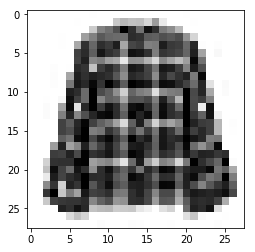

LABEL: 6


In [13]:
NN_prediction = best_ffnn.predict(X_test)
large_NN_prediction = best_NN_large.predict(X_test)

wrong_index = []
for i in range(len(y_test)):
    if (large_NN_prediction[i] == y_test[i]) and (NN_prediction[i] != y_test[i]):
        wrong_index.append(i)

# Select a random image
j = wrong_index[np.random.randint(0, len(wrong_index))]
print("Image "+str(j))
print("NN prediction =",   NN_prediction[j])
print("Large NN prediction =", large_NN_prediction[j])
plot_input(X_test,y_test,j)        

Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 500 data points and with 50000 data points. Notice that the code assumes that the NNs are called "mlp" and "best_mlp_large" , you could need to replace with your variable names.



Weights with 500 data points:


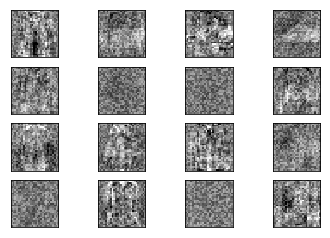

Weights with 10000 data points:


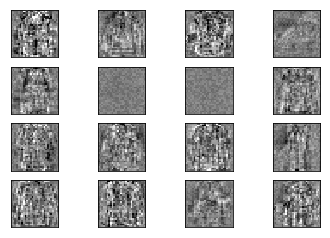

In [14]:
print("Weights with 500 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = best_ffnn.coefs_[0].min(), best_ffnn.coefs_[0].max()
for coef, ax in zip(best_ffnn.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin, vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 10000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = best_NN_large.coefs_[0].min(), best_NN_large.coefs_[0].max()
for coef, ax in zip(best_NN_large.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin, vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

## QUESTION 4

Describe what do you observe by looking at the weights

The images are very small, grey and with a very low definition, such that it is hard to distinguish anything at all.
However, it seems that the pictures with 10,000 data points have a lower background noise, in the sense that they look "cleaner" and more uniform.

### TO DO 7

Report the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores.

In [15]:
m_training = 5000

X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]

# In my previous notebook the best SVM was the one using a linear kernel with C=0.1

# Create the SVM and perform the fit
best_SVM = SVC(C=0.1,kernel="linear")
best_SVM.fit(X_train,y_train)

print ('RESULTS FOR SVM')

SVM_training_error = 1. - best_SVM.score(X_train,y_train)
print("Training score SVM:")
print(SVM_training_error)

SVM_test_error = 1. - best_SVM.score(X_test,y_test)
print("Test score SVM:")
print(SVM_test_error)

RESULTS FOR SVM
Training score SVM:
0.07379999999999998
Test score SVM:
0.15480000000000005


## QUESTION 5
Compare the results of SVM and of NN. Which one would you preferer? Which are its tradeoffs?

The results between NNs and SVM are as follow: the training errors are 0.002 and 0.074 respectively, while the test errors are almost the same, 0.150 and 0.155 (considering their best performance over 10,000 data points).

For the specific task of image classification, it seems in my opinion that Neural Networks are preferable over SVM: they are much faster (they do not need to select a model, for instance), more flexible and way more performing at feature extraction. However, on the other hand, SVM has a regularization parameter which generally makes it less prone to overfitting than NNs; also, a global and unique solution is guaranteed. One last aspect to consider is the number of (hyper)parameters: NNs need to be provided with less hyperparameters than SVM, which makes them at the same time more "multi-purpose" and straightforward yet, in a way, conceptually more obscure. 